In [136]:
import warnings
import pandas as pd
import torch
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback
import numpy as np

In [137]:
%matplotlib inline

In [138]:
input_df = pd.read_csv('finbert_600.csv')
df = input_df[['title','ground_truth']]
df.columns = ['news','labels']
df

,news,labels
0,Nigella Lawson reveals her favourite Australia...,0
1,"In nostalgia trip , Tata Sky Seniors brings ba...",0
2,Buying Myself Back : Emily Ratajkowski is mint...,1
3,Thousands of Johnson & Johnson COVID - 19 vacc...,0
4,Hillicon Valley : Huawei to move toward softwa...,-1
...,...,...
595,Markets in first - quarter : Riding a tiger an...,0
596,Business Highlights,0
597,Markets in first quarter : Riding a tiger and ...,0
598,Markets in first - quarter : Riding a tiger an...,0


In [139]:
df['labels'].replace({1:2},inplace=True)
df['labels'].replace({0:1},inplace=True)
df['labels'].replace({-1:0},inplace=True)
df

,news,labels
0,Nigella Lawson reveals her favourite Australia...,1
1,"In nostalgia trip , Tata Sky Seniors brings ba...",1
2,Buying Myself Back : Emily Ratajkowski is mint...,2
3,Thousands of Johnson & Johnson COVID - 19 vacc...,1
4,Hillicon Valley : Huawei to move toward softwa...,0
...,...,...
595,Markets in first - quarter : Riding a tiger an...,1
596,Business Highlights,1
597,Markets in first quarter : Riding a tiger and ...,1
598,Markets in first - quarter : Riding a tiger an...,1


In [140]:
df['labels'].value_counts()

labels
1    291
2    214
0     95
Name: count, dtype: int64

In [141]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['news'] = df['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df["news"] = df["news"].str.lower()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZLIU5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [142]:
# removes punctuation and special characters using a regular expression ([^\w\s]), leaving only words and whitespace.
import string
df["news"] = df['news'].str.replace('[^\w\s]','')
print(df['news'])

0      nigella lawson reveals favourite australian fo...
1      in nostalgia trip , tata sky seniors brings ba...
2      buying myself back : emily ratajkowski minting...
3      thousands johnson & johnson covid - 19 vaccine...
4      hillicon valley : huawei move toward software ...
                             ...                        
595    markets first - quarter : riding tiger waking ...
596                                  business highlights
597    markets first quarter : riding tiger waking bears
598    markets first - quarter : riding tiger waking ...
599    sino united worldwide consolidated ltd .: suic...
Name: news, Length: 600, dtype: object


In [143]:
# imports and downloads resources for lemmatization, which reduces words to their root forms, 'running' to 'run'
# the function tokenizes each sentence, lemmatizes each word, and joins the words back into a single string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
lemmatizer = WordNetLemmatizer()

#Function to apply for each word the proper lemmatization.
def lemmetize_titles(words):
    a = []
    tokens = word_tokenize(words)
    for token in tokens:
        lemmetized_word = lemmatizer.lemmatize(token)
        a.append(lemmetized_word)
    lemmatized_title = ' '.join(a)
    return lemmatized_title

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZLIU5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZLIU5\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ZLIU5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [144]:
df['lemmetized_titles'] = df['news'].apply(lemmetize_titles)
df

,news,labels,lemmetized_titles
0,nigella lawson reveals favourite australian fo...,1,nigella lawson reveals favourite australian fo...
1,"in nostalgia trip , tata sky seniors brings ba...",1,"in nostalgia trip , tata sky senior brings bac..."
2,buying myself back : emily ratajkowski minting...,2,buying myself back : emily ratajkowski minting...
3,thousands johnson & johnson covid - 19 vaccine...,1,thousand johnson & johnson covid - 19 vaccine ...
4,hillicon valley : huawei move toward software ...,0,hillicon valley : huawei move toward software ...
...,...,...,...
595,markets first - quarter : riding tiger waking ...,1,market first - quarter : riding tiger waking b...
596,business highlights,1,business highlight
597,markets first quarter : riding tiger waking bears,1,market first quarter : riding tiger waking bear
598,markets first - quarter : riding tiger waking ...,1,market first - quarter : riding tiger waking bear


In [145]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [146]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [147]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

class PlotEvalMetricsCallback(TrainerCallback):
    def __init__(self):
        self.epochs = []
        self.eval_loss = []
        self.eval_accuracy = []

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        epoch = state.epoch
        self.epochs.append(epoch)
        self.eval_loss.append(metrics.get("eval_loss"))
        self.eval_accuracy.append(metrics.get("eval_accuracy"))

        clear_output(wait=True)
        print(f"Evaluation Loss: {self.eval_loss}")
        print(f"Epochs: {self.epochs}")
        print(f"Evaluation Accuracy: {self.eval_accuracy}")

        plt.figure(figsize=(16, 6))

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.eval_loss, label="Validation Loss", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Validation Loss")
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.eval_accuracy, label="Validation Accuracy", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy")
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.tight_layout()
        plt.show()

In [148]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

class PlotMetricsCallback(TrainerCallback):
    def __init__(self):
        self.epochs = []

        # Evaluation metrics
        self.eval_loss = []
        self.eval_accuracy = []

        # Training metrics
        self.train_loss = []
        self.train_accuracy = []

    def on_log(self, args, state, control, logs=None, **kwargs):

        print("Logs:", logs)
        logs = logs or {}
        epoch = state.epoch
        if epoch is not None and (logs.get("loss") is not None or logs.get("accuracy") is not None):
            if len(self.epochs) == 0 or self.epochs[-1] != epoch:
                self.epochs.append(epoch)
                self.train_loss.append(logs.get("loss", None))
                self.train_accuracy.append(logs.get("accuracy", None))

    def on_evaluate(self, args, state, control, metrics, **kwargs):

        print("Evaluation Metrics:", metrics)
        epoch = state.epoch
        if epoch not in self.epochs:
            self.epochs.append(epoch)
            self.train_loss.append(None)
            self.train_accuracy.append(None)

        self.eval_loss.append(metrics.get("eval_loss"))
        self.eval_accuracy.append(metrics.get("eval_accuracy"))

        clear_output(wait=True)
        print(f"Epochs: {self.epochs}")
        print(f"Training Loss: {self.train_loss}")
        print(f"Eval Loss: {self.eval_loss}")
        print(f"Training Accuracy: {self.train_accuracy}")
        print(f"Eval Accuracy: {self.eval_accuracy}")

        plt.figure(figsize=(16, 6))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.train_loss, label="Training Loss", marker='o')
        plt.plot(self.epochs, self.eval_loss, label="Validation Loss", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.train_accuracy, label="Training Accuracy", marker='o')
        plt.plot(self.epochs, self.eval_accuracy, label="Validation Accuracy", marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training vs Validation Accuracy")
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.tight_layout()
        plt.show()


In [149]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')   
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')        
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')                 

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [150]:
X = list(df["lemmetized_titles"])
y = list(df["labels"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)
train_dataset = Dataset(X_train_tokenized, y_train)
test_dataset = Dataset(X_test_tokenized, y_test)

In [151]:
args = TrainingArguments(
    output_dir="fourth_test",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=40,
    seed=0,
    disable_tqdm=True,
    report_to="none",
    learning_rate=5e-5,
    weight_decay=0.05,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=True,  # load best eval model at end
    metric_for_best_model="eval_accuracy"  # Required if loading best model
)


Epochs: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
Training Loss: [1.5672, 0.8603, 0.5142, 0.2778, 0.1267, 0.142, 0.0393, 0.0028, 0.0224, 0.0172, 0.0103, 0.0007, 0.0006, 0.0003, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
Eval Loss: [0.984187126159668, 0.7198750972747803, 0.9447770714759827, 1.0693998336791992, 1.6084179878234863, 1.7210978269577026, 1.5606156587600708, 1.7906908988952637, 1.928809642791748, 1.841245412826538, 1.967405915260315, 2.2523343563079834, 2.1453044414520264, 2.083719491958618, 2.098792552947998, 2.1225547790527344, 2.1557960510253906, 2.175354242324829, 2.268984317779541, 2.279796838760376, 2.291653871536255, 2.3

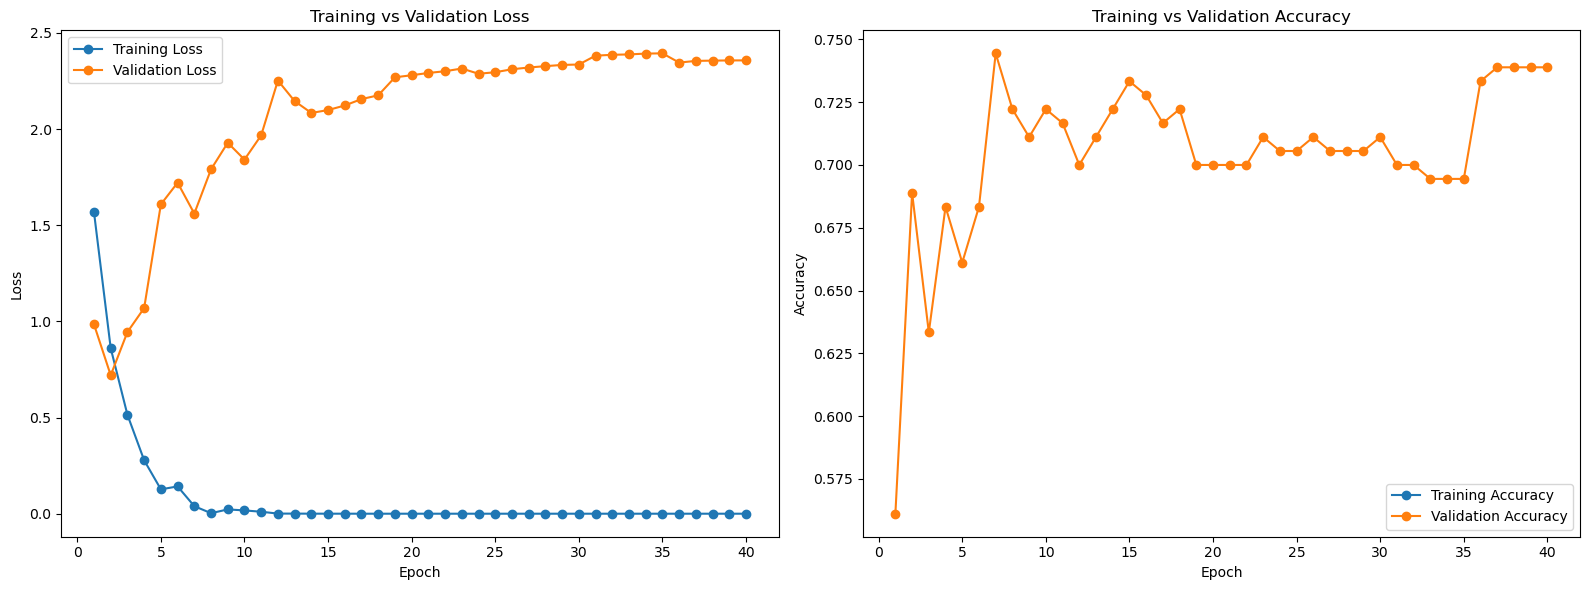

Logs: {'train_runtime': 214.436, 'train_samples_per_second': 78.345, 'train_steps_per_second': 9.886, 'total_flos': 647505676440000.0, 'train_loss': 0.08959840661165182, 'epoch': 40.0}
{'train_runtime': 214.436, 'train_samples_per_second': 78.345, 'train_steps_per_second': 9.886, 'train_loss': 0.08959840661165182, 'epoch': 40.0}


TrainOutput(global_step=2120, training_loss=0.08959840661165182, metrics={'train_runtime': 214.436, 'train_samples_per_second': 78.345, 'train_steps_per_second': 9.886, 'train_loss': 0.08959840661165182, 'epoch': 40.0})

In [152]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[PlotMetricsCallback()],
)


trainer.train()